# 0. Design

### 0_1. 데이터 정의
- 입력 데이터는 1.csv, 2.csv, 3.csv, ... 와 같이 n.csv 형식의 파일
    - 입력 데이터: 악보 정보 (노트, 강도, 페달 등)
- 정답 데이터는 1_target.csv, 2_target.csv, 3_target.csv, ... 와 같이 n_target.csv 형식의 파일
    - 정답 데이터: 각 기준별 평가 점수
    
### 0_2. 데이터 전처리 방법
- input data
    - sec: 가만히 유지
    - msg_type: note_on, note_off 정보는 딥러닝 학습에 무의미하므로 삭제
    - channel: 삭제
    - note: MinMaxScaler (노트값은 데이터 분포가 정규 분포를 따르지 않을 가능성 ↑. 추가 실험 예정)
    - velocity: StandardScaler (velocity는 일정 정규 분포를 따를 가능성 ↑. 추가 실험 예정)
    - dynamic: One-Hot Encoding (각 강도 값을 고유한 벡터로 변환하여 모델이 더 쉽게 학습할 수 있도록 합니다.)
    - padal: StandardScaler
    - count: 삭제 (음악 정보와 관련성이 낮다고 판단)
    - main_vol: 삭제 (음악 정보와 관련성이 낮다고 판단)
    - depth: 삭제 (음악 정보와 관련성이 낮다고 판단)
    - pan: 삭제 (음악 정보와 관련성이 낮다고 판단)
    
### 0_3. 모델 선택 및 이유
- RNN & LSTM
    - 본 연구의 경우 입력 데이터의 행의 수가 연주된 곡의 길이에 따라 전부 다름(시간 의존성 내포)
    - 피아노 연주의 경우 이전의 연주가 다음의 연주와 이어지는 Sequence Data이므로 이를 처리하는데 적합한 RNN 모델을 선택
    - 또한, RNN 모델의 경우 긴 시퀀스 데이터의 경우 vanishing gradient 혹은 exploding gradient 문제가 발생하기 때문에 LSTM 모델을 선택
        - LSTM 모델은 셀 내부에 게이트 메커니즘을 사용하여 과거 정보를 유지하고 불필요한 정보를 잊도록 설계되어 이러한 문제를 해결

# 1. Import Libraries

In [297]:
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Embedding, Dropout
from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import os

# 2. Data Load & Preprocessing

### 2_1. Normalization

In [298]:
def load_data(filenames, max_length):
    input_data = []
    target_data = []

    scaler_note = MinMaxScaler()
    scaler_velocity = StandardScaler()
    scaler_pedal = StandardScaler()

    for filename in filenames:
        df = pd.read_csv('./data/input/' + filename)

        df.drop(['msg_type', 'channel', 'count', 'main_vol', 'depth', 'pan'], axis=1, inplace=True)

        df['note'] = df['note'].apply(lambda x: [int(i) for i in str(x).strip('[]').split(', ') if i != ''])
        df['velocity'] = df['velocity'].apply(lambda x: [int(i) for i in str(x).strip('[]').split(', ') if i != ''])
        df['pedal'] = df['pedal'].apply(lambda x: [int(i) for i in str(x).strip('[]').split(', ') if i != ''])

        df['note'] = df['note'].apply(lambda x: x if x else [0])
        df['velocity'] = df['velocity'].apply(lambda x: x if x else [0])
        df['pedal'] = df['pedal'].apply(lambda x: x if x else [0])

        # Padding sequences
        df['note'] = pad_sequences(df['note'], max_length)
        df['velocity'] = pad_sequences(df['velocity'], max_length)
        df['pedal'] = pad_sequences(df['pedal'], max_length)

        # Normalize 'note', 'velocity', and 'pedal' columns
        df['note'] = df['note'].apply(lambda x: scaler_note.fit_transform(np.array(x).reshape(-1, 1)).flatten())
        df['velocity'] = df['velocity'].apply(lambda x: scaler_velocity.fit_transform(np.array(x).reshape(-1, 1)).flatten())
        df['pedal'] = df['pedal'].apply(lambda x: scaler_pedal.fit_transform(np.array(x).reshape(-1, 1)).flatten())

        # One-hot encode 'dynamic' column if it exists
        if 'dynamic' in df.columns:
            encoder = OneHotEncoder(sparse_output=False, categories='auto', drop=None, handle_unknown='ignore')
            encoded_dynamic = encoder.fit_transform(df[['dynamic']])
            encoded_dynamic_array = np.array(encoded_dynamic)
            df.drop(['dynamic'], axis=1, inplace=True)
            df['dynamic'] = encoded_dynamic_array.tolist()

        data = df.to_numpy()

        # Append data for each file
        input_data.append(data)

        # Load target data
        target_filename = filename.replace('.csv', '_target.csv')
        df_target = pd.read_csv('./data/target/' + target_filename)
        target_data.append(df_target.to_numpy())

    return input_data, target_data

# 패딩 함수
def pad_sequences(data, max_length):
    padded_data = []
    for sequence in data:
        if len(sequence) < max_length:
            padded_sequence = sequence + [0] * (max_length - len(sequence))
        else:
            padded_sequence = sequence[:max_length]
        padded_data.append(padded_sequence)
    return padded_data

In [299]:
input_data, target_data = load_data(filenames, max_length)
filenames = ['1.csv', '2.csv', '3.csv'] # 나중에 반복문으로 자동화
max_length = 30  # 패딩 최대 길이

input_data, target_data = load_data(filenames, max_length)

print('Sample from input data files:')
print(f'The number of input data: {len(input_data)}')
print(input_data[0][10:25])
print(input_data[0].shape)
print(input_data[1].shape)
print(input_data[2].shape)

print()

print('Sample from target data files:')
print(f'The number of input data: {len(input_data)}')
print(target_data[0][0])
print(target_data[1][0])
print(target_data[2][0])
print(target_data[0].shape)
print(target_data[1].shape)
print(target_data[2].shape)

Sample from input data files:
The number of input data: 3
[[1.0
  array([1.   , 1.   , 0.825, 0.825, 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   ])
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  0
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  list([0.0, 0.0, 0.0, 1.0, 0.0])]
 [1.1
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  0
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

In [310]:
train = []
target = []

for i in range(len(input_data[0])):
    train.append(input_data[0][i][1])
    target.append(y_train[0])

train = np.array(train)
target = np.array(target)
print(train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]]


### 2_2. Split Dataset
- 1. 배열 속 데이터를 섞을지?
- 2. 파일을 먼저 섞고 불러올지?

In [53]:
os.makedirs("./data/train/input", exist_ok=True)
os.makedirs("./data/train/target", exist_ok=True)
os.makedirs("./data/val/input", exist_ok=True)
os.makedirs("./data/val/target", exist_ok=True)
os.makedirs("./data/test/input", exist_ok=True)
os.makedirs("./data/test/target", exist_ok=True)

In [54]:
input_data_dir = "./data/input"
target_data_dir = "./data/target"
input_filenames = os.listdir(input_data_dir)

# target_filenames 생성
target_filenames = [filename.replace('.csv', '_target.csv') for filename in input_filenames]

print(input_filenames)
print(target_filenames)

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

random.shuffle(input_filenames)

train_filenames = input_filenames[:int(len(input_filenames) * train_ratio)]
val_filenames = input_filenames[int(len(input_filenames) * train_ratio):int(len(input_filenames) * (train_ratio + val_ratio))]
test_filenames = input_filenames[int(len(input_filenames) * (train_ratio + val_ratio)):]

for filename in train_filenames:
    input_filepath = os.path.join(input_data_dir, filename)
    target_filepath = os.path.join(target_data_dir, target_filenames[input_filenames.index(filename)])
    if os.path.exists(target_filepath):  # 대응되는 타겟 파일이 존재하는 경우에만 이동
        os.rename(input_filepath, os.path.join("./data/train/input", filename))
        os.rename(target_filepath, os.path.join("./data/train/target", target_filenames[input_filenames.index(filename)]))
        print(f'{filename}이 train 폴더로 이동, target 파일 동일')

for filename in val_filenames:
    input_filepath = os.path.join(input_data_dir, filename)
    target_filepath = os.path.join(target_data_dir, target_filenames[input_filenames.index(filename)])
    if os.path.exists(target_filepath):  # 대응되는 타겟 파일이 존재하는 경우에만 이동
        os.rename(input_filepath, os.path.join("./data/val/input", filename))
        os.rename(target_filepath, os.path.join("./data/val/target", target_filenames[input_filenames.index(filename)]))
        print(f'{filename}이 val 폴더로 이동, target 파일 동일')

for filename in test_filenames:
    input_filepath = os.path.join(input_data_dir, filename)
    target_filepath = os.path.join(target_data_dir, target_filenames[input_filenames.index(filename)])
    if os.path.exists(target_filepath):  # 대응되는 타겟 파일이 존재하는 경우에만 이동
        os.rename(input_filepath, os.path.join("./data/test/input", filename))
        os.rename(target_filepath, os.path.join("./data/test/target", target_filenames[input_filenames.index(filename)]))
        print(f'{filename}이 test 폴더로 이동, target 파일 동일')

['1.csv', '2.csv', '3.csv']
['1_target.csv', '2_target.csv', '3_target.csv']
2.csv이 train 폴더로 이동, target 파일 동일
1.csv이 train 폴더로 이동, target 파일 동일
3.csv이 test 폴더로 이동, target 파일 동일


In [31]:
# Split data into training and test sets (80% train, 20% test)
filenames = ['1.csv', '2.csv', '3.csv']  # Replace with actual filenames

np.random.shuffle(filenames)

split_index = int(0.8 * len(filenames))

# Training filenames
train_filenames = filenames[:split_index]

# Test filenames
test_filenames = filenames[split_index:]

# Load training data
x_train, y_train = load_data(train_filenames)

# Load test data
x_test, y_test = load_data(test_filenames)

# 3. Implement Models

In [301]:
num_features = x_data[0].shape[1]
num_outputs = y_data[0].shape[1]

### 3_1. RNN

In [336]:
# 1. Create a RNN model
model = Sequential([
    Embedding(input_dim=num_features, output_dim=128),
    # Use the SimpleRNN layer for a basic RNN
    SimpleRNN(128, activation='relu', return_sequences=True),
    SimpleRNN(128, activation='relu'),
    Dropout(0.3),
    Dense(num_outputs)
])

# 2. Summarization
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 128)         768       
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, None, 128)         32896     
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 6)                 774       
                                                                 
Total params: 67334 (263.02 KB)
Trainable params: 67334 (263.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [337]:
x_train = []

for array in train:
    x_train.append(train.reshape(-1))  # Flatten

print(x_train)

[array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 

In [338]:
# 3. Train the model
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
model.fit(train, target, epochs=100)

Epoch 1/100
55/55 [==============================] - 1s 4ms/step - loss: 12.5694 - mae: 2.5566
Epoch 2/100
55/55 [==============================] - 0s 5ms/step - loss: 1.9351 - mae: 1.0831
Epoch 3/100
55/55 [==============================] - 0s 4ms/step - loss: 1.3981 - mae: 0.9119
Epoch 4/100
55/55 [==============================] - 0s 4ms/step - loss: 1.1062 - mae: 0.8116
Epoch 5/100
55/55 [==============================] - 0s 5ms/step - loss: 0.9894 - mae: 0.7551
Epoch 6/100
55/55 [==============================] - 0s 5ms/step - loss: 0.8667 - mae: 0.7024
Epoch 7/100
55/55 [==============================] - 0s 5ms/step - loss: 0.7649 - mae: 0.6561
Epoch 8/100
55/55 [==============================] - 0s 5ms/step - loss: 0.7134 - mae: 0.6279
Epoch 9/100
55/55 [==============================] - 0s 4ms/step - loss: 0.6873 - mae: 0.6141
Epoch 10/100
55/55 [==============================] - 0s 5ms/step - loss: 0.6592 - mae: 0.5927
Epoch 11/100
55/55 [==============================] - 0s 5

In [340]:
history = model.fit(train, target, epochs=100)

Epoch 1/100
55/55 [==============================] - 0s 4ms/step - loss: 0.1351 - mae: 0.2368
Epoch 2/100
55/55 [==============================] - 0s 4ms/step - loss: 0.1433 - mae: 0.2407
Epoch 3/100
55/55 [==============================] - 0s 4ms/step - loss: 0.1353 - mae: 0.2320
Epoch 4/100
55/55 [==============================] - 0s 5ms/step - loss: 0.1393 - mae: 0.2385
Epoch 5/100
55/55 [==============================] - 0s 5ms/step - loss: 0.1342 - mae: 0.2302
Epoch 6/100
55/55 [==============================] - 0s 4ms/step - loss: 0.1262 - mae: 0.2273
Epoch 7/100
55/55 [==============================] - 0s 4ms/step - loss: 0.1410 - mae: 0.2374
Epoch 8/100
55/55 [==============================] - 0s 4ms/step - loss: 0.1346 - mae: 0.2309
Epoch 9/100
55/55 [==============================] - 0s 4ms/step - loss: 0.1316 - mae: 0.2321
Epoch 10/100
55/55 [==============================] - 0s 4ms/step - loss: 0.1360 - mae: 0.2303
Epoch 11/100
55/55 [==============================] - 0s 4m

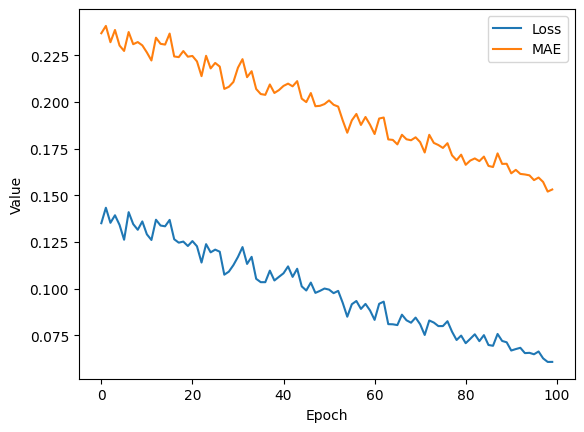

In [341]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['mae'], label='MAE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

In [342]:
new_data = np.array([
    [0.61728395, 0.61728395, 1, 0, 0, 0],
    [0.12345678, 0.23456789, 0.34567890, 0.45678901, 0.56789012, 0.67890123],
    [0.98765432, 0.87654321, 0.76543210, 0.65432109, 0.54321098, 0.43210987],
    [0.01234567, 0.02345678, 0.03456789, 0.04567890, 0.05678901, 0.06789012],
    [0.10000000, 0.20000000, 0.30000000, 0.40000000, 0.50000000, 0.60000000],
    [0.90000000, 0.80000000, 0.70000000, 0.60000000, 0.50000000, 0.40000000],
    [0.55555556, 0.55555556, 0.55555556, 0.55555556, 0.55555556, 0.55555556],
    [0.44444444, 0.44444444, 0.44444444, 0.44444444, 0.44444444, 0.44444444],
    [0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333],
    [0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222]
]).reshape(10, 6)

predictions = model.predict(new_data)

df = pd.DataFrame(predictions)

print(df)

1/1 [==============================] - 0s 99ms/step
          0         1         2         3    4             5
0  8.615493  7.692060  6.769523  5.839771  1.0 -1.088628e-07
1  9.023914  8.017573  7.011151  6.005275  1.0 -7.552671e-09
2  9.023914  8.017573  7.011151  6.005275  1.0 -7.552671e-09
3  9.023914  8.017573  7.011151  6.005275  1.0 -7.552671e-09
4  9.023914  8.017573  7.011151  6.005275  1.0 -7.552671e-09
5  9.023914  8.017573  7.011151  6.005275  1.0 -7.552671e-09
6  9.023914  8.017573  7.011151  6.005275  1.0 -7.552671e-09
7  9.023914  8.017573  7.011151  6.005275  1.0 -7.552671e-09
8  9.023914  8.017573  7.011151  6.005275  1.0 -7.552671e-09
9  9.023914  8.017573  7.011151  6.005275  1.0 -7.552671e-09


In [330]:
# 4. Evaluate the model
#loss, mae = model.evaluate(x_test, y_test)
#print('Loss:', loss)
#print('MAE:', mae)

### 3_2. LSTM

In [343]:
# 1. Create a LSTM model
model = Sequential([
    Embedding(input_dim=num_features, output_dim=128),
    LSTM(128, activation='relu', return_sequences=True),
    LSTM(128, activation='relu'),
    Dropout(0.3),
    Dense(num_outputs)
])

# 2. Summarization
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 128)         768       
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         131584    
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 6)                 774       
                                                                 
Total params: 264710 (1.01 MB)
Trainable params: 264710 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [344]:
# 3. Train the model
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
model.fit(train, target, epochs=100)

Epoch 1/100
55/55 [==============================] - 2s 23ms/step - loss: 49.1153 - mae: 5.0968
Epoch 2/100
55/55 [==============================] - 1s 24ms/step - loss: 25.4913 - mae: 4.0208
Epoch 3/100
55/55 [==============================] - 1s 24ms/step - loss: 2.4791 - mae: 1.2375
Epoch 4/100
55/55 [==============================] - 1s 24ms/step - loss: 1.6005 - mae: 1.0006
Epoch 5/100
55/55 [==============================] - 1s 24ms/step - loss: 1.3041 - mae: 0.8972
Epoch 6/100
55/55 [==============================] - 1s 24ms/step - loss: 1.1770 - mae: 0.8464
Epoch 7/100
55/55 [==============================] - 1s 24ms/step - loss: 1.0007 - mae: 0.7774
Epoch 8/100
55/55 [==============================] - 1s 24ms/step - loss: 0.9876 - mae: 0.7666
Epoch 9/100
55/55 [==============================] - 1s 25ms/step - loss: 0.8813 - mae: 0.7227
Epoch 10/100
55/55 [==============================] - 1s 24ms/step - loss: 0.9029 - mae: 0.7232
Epoch 11/100
55/55 [===========================

In [345]:
history = model.fit(train, target, epochs=100)

Epoch 1/100
55/55 [==============================] - 1s 24ms/step - loss: 0.3120 - mae: 0.3750
Epoch 2/100
55/55 [==============================] - 1s 24ms/step - loss: 0.3024 - mae: 0.3691
Epoch 3/100
55/55 [==============================] - 1s 24ms/step - loss: 0.3020 - mae: 0.3697
Epoch 4/100
55/55 [==============================] - 1s 24ms/step - loss: 0.3107 - mae: 0.3757
Epoch 5/100
55/55 [==============================] - 1s 24ms/step - loss: 0.2861 - mae: 0.3581
Epoch 6/100
55/55 [==============================] - 1s 24ms/step - loss: 0.2881 - mae: 0.3606
Epoch 7/100
55/55 [==============================] - 1s 24ms/step - loss: 0.2919 - mae: 0.3631
Epoch 8/100
55/55 [==============================] - 1s 25ms/step - loss: 0.3010 - mae: 0.3641
Epoch 9/100
55/55 [==============================] - 1s 24ms/step - loss: 0.2821 - mae: 0.3567
Epoch 10/100
55/55 [==============================] - 1s 25ms/step - loss: 0.2857 - mae: 0.3603
Epoch 11/100
55/55 [=============================

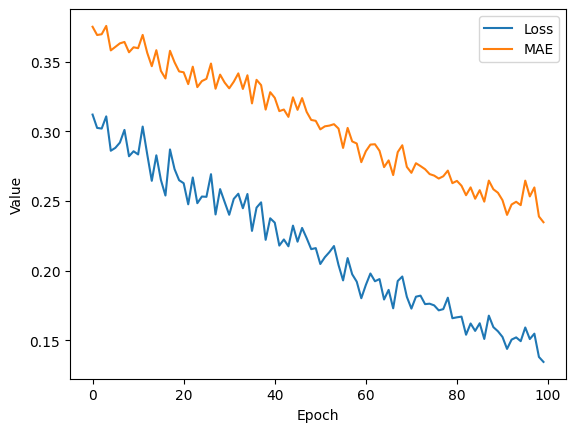

In [346]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['mae'], label='MAE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

In [347]:
new_data = np.array([
    [0.61728395, 0.61728395, 1, 0, 0, 0],
    [0.12345678, 0.23456789, 0.34567890, 0.45678901, 0.56789012, 0.67890123],
    [0.98765432, 0.87654321, 0.76543210, 0.65432109, 0.54321098, 0.43210987],
    [0.01234567, 0.02345678, 0.03456789, 0.04567890, 0.05678901, 0.06789012],
    [0.10000000, 0.20000000, 0.30000000, 0.40000000, 0.50000000, 0.60000000],
    [0.90000000, 0.80000000, 0.70000000, 0.60000000, 0.50000000, 0.40000000],
    [0.55555556, 0.55555556, 0.55555556, 0.55555556, 0.55555556, 0.55555556],
    [0.44444444, 0.44444444, 0.44444444, 0.44444444, 0.44444444, 0.44444444],
    [0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333],
    [0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222, 0.22222222]
]).reshape(10, 6)

predictions = model.predict(new_data)

df = pd.DataFrame(predictions)

print(df)

1/1 [==============================] - 0s 118ms/step
          0         1         2         3         4         5
0  3.509154  3.334871  3.165438  2.963407  0.951917 -0.016189
1  3.534979  3.356847  3.183925  2.978028  0.952147 -0.016364
2  3.534979  3.356847  3.183925  2.978028  0.952147 -0.016364
3  3.534979  3.356847  3.183925  2.978028  0.952147 -0.016364
4  3.534979  3.356847  3.183925  2.978028  0.952147 -0.016364
5  3.534979  3.356847  3.183925  2.978028  0.952147 -0.016364
6  3.534979  3.356847  3.183925  2.978028  0.952147 -0.016364
7  3.534979  3.356847  3.183925  2.978028  0.952147 -0.016364
8  3.534979  3.356847  3.183925  2.978028  0.952147 -0.016364
9  3.534979  3.356847  3.183925  2.978028  0.952147 -0.016364


In [331]:
# 4. Evaluate the model
#loss, mae = model.evaluate(x_test, y_test)
#print('Loss:', loss)
#print('MAE:', mae)